In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/target_CHEMBL240-1.IC50_ready.csv.gz", compression="gzip")
df

,Standardized_SMILES,pchembl_value
0,Brc1cncc(COCC2(c3ccccc3)CCNCC2)c1,4.82
1,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCCCC...,6.70
2,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCCCC...,6.47
3,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCOCC...,5.39
4,C1=NCCC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCC...,7.05
...,...,...
1257,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(-c2cscn2...,5.36
1258,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C24CC5CC...,6.30
1259,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C2CCCCC2...,6.87
1260,c1cncc(-c2c[nH]c(C3Cc4c([nH]c5ccccc45)C(C4CCCC...,6.72


In [16]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)

def calculate_molwt(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return Descriptors.MolWt(mol)
    return None

def calculate_logp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return Descriptors.MolLogP(mol)
    return None

df['MolWt'] =df['Standardized_SMILES'].apply(calculate_molwt)
df['LogP'] = df['Standardized_SMILES'].apply(calculate_logp)


INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [17]:
df

,Standardized_SMILES,pchembl_value,MolWt,LogP
0,Brc1cncc(COCC2(c3ccccc3)CCNCC2)c1,4.82,361.283,3.6821
1,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCCCC...,6.70,397.526,6.4497
2,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCCCC...,6.47,398.514,4.8690
3,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCOCC...,5.39,399.498,5.2960
4,C1=NCCC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCC...,7.05,397.526,6.1021
...,...,...,...,...
1257,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(-c2cscn2...,5.36,405.527,4.3692
1258,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C24CC5CC...,6.30,456.634,5.7135
1259,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C2CCCCC2...,6.87,404.558,5.2934
1260,c1cncc(-c2c[nH]c(C3Cc4c([nH]c5ccccc45)C(C4CCCC...,6.72,397.526,5.4614


In [18]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np
import matplotlib.pyplot as plt

In [26]:
# Generate Morgan Fingerprints
def generate_fingerprints(smiles, radius=2, nBits=20488):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    else:
        return np.zeros((nBits,))

df['Fingerprints'] = df['Standardized_SMILES'].apply(generate_fingerprints)

# Prepare features and target
X = np.array(list(df['Fingerprints']))
y = df['pchembl_value'].values

In [27]:
smiles = df['Standardized_SMILES'].values

In [28]:
MolWt = df['MolWt'].values
LogP = df['LogP'].values

In [29]:
X

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [30]:
y

array([4.82, 6.7 , 6.47, ..., 6.87, 6.72, 5.57])

In [31]:
smiles

array(['Brc1cncc(COCC2(c3ccccc3)CCNCC2)c1',
       'C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCCCC4)n3)n2)CCC1',
       'C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCCCC4)n3)n2)CNC1', ...,
       'c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C2CCCCC2)c[nH]1)C3',
       'c1cncc(-c2c[nH]c(C3Cc4c([nH]c5ccccc45)C(C4CCCCC4)N3)n2)c1',
       'c1cncc(-c2c[nH]c(C3Cc4c([nH]c5ccccc45)C(C4CCOCC4)N3)n2)c1'],
      dtype=object)

In [1]:
df[df["LogP"]>2,]

NameError: name 'df' is not defined

In [34]:
def plot_graphs(data, results_df):
    
    results_df =pd.merge(data, results_df, 
                         left_on="Standardized_SMILES", right_on="Standardized_SMILES")
    
    # Calculate absolute errors and adjust results
    results_df['Error'] = (results_df['True Values'] - results_df['Predictions']).abs().round(2)
    results_df['True Values'] = results_df['True Values'].round(2)
    results_df['Predictions'] = results_df['Predictions'].round(2)

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['MolWt'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By MolWt')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['LogP'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By LogP')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['pchembl_value'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By IC50 Sorted')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()

In [35]:
# Random Forest Model
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

def perform_cv(X, y, smiles, model, k=10):
    cv = KFold(n_splits=k, shuffle=True, random_state=42)
    predictions = cross_val_predict(model, X, y, cv=cv)

    # Plot predictions vs true values
    plt.scatter(y, predictions)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("Cross-Validation Prediction")
    plt.show()

    # Saving results to a DataFrame
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles,
        'pchembl_value': y,
        'Predictions': predictions
    })

    # Saving to CSV (optional)
    results_df.to_csv("cv_results.csv", index=False)

    return results_df

In [86]:
# Execute CV
# Example Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Execute Cross-Validation
results_df = perform_cv(X, y, smiles, rf_model)



KeyboardInterrupt



In [36]:
results_df=pd.read_csv("data/cv_results.csv")

In [37]:
results_df

,Standardized_SMILES,True Values,Predictions
0,Brc1cncc(COCC2(c3ccccc3)CCNCC2)c1,4.82,5.01235
1,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCCCC...,6.70,6.49050
2,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCCCC...,6.47,6.60920
3,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCOCC...,5.39,6.10935
4,C1=NCCC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCC...,7.05,6.12280
...,...,...,...
1257,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(-c2cscn2...,5.36,6.68685
1258,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C24CC5CC...,6.30,6.19530
1259,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C2CCCCC2...,6.87,6.41660
1260,c1cncc(-c2c[nH]c(C3Cc4c([nH]c5ccccc45)C(C4CCCC...,6.72,5.98270


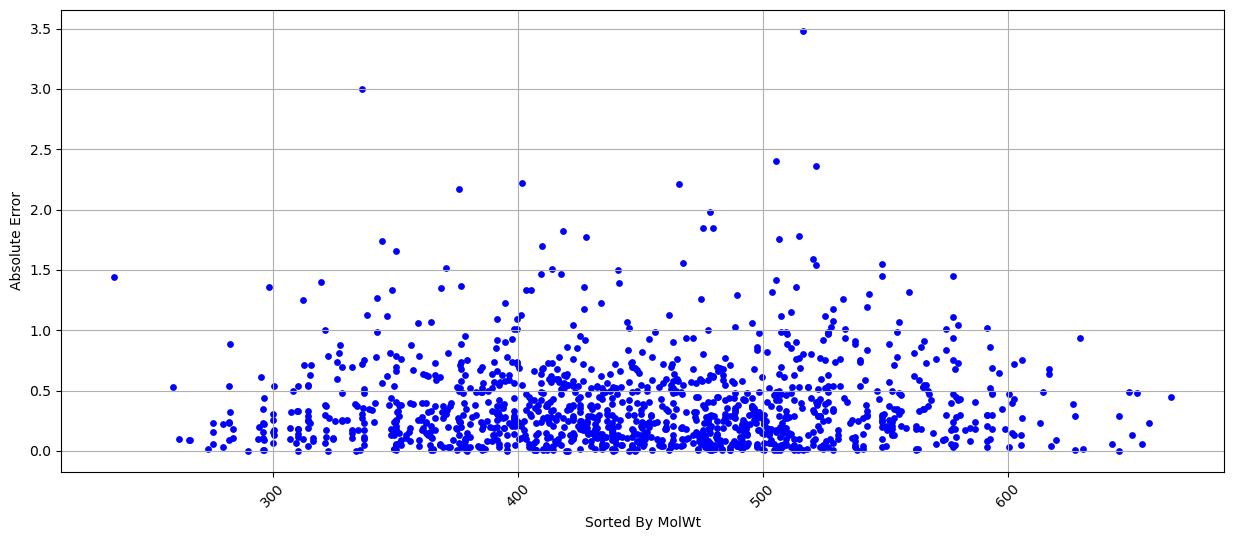

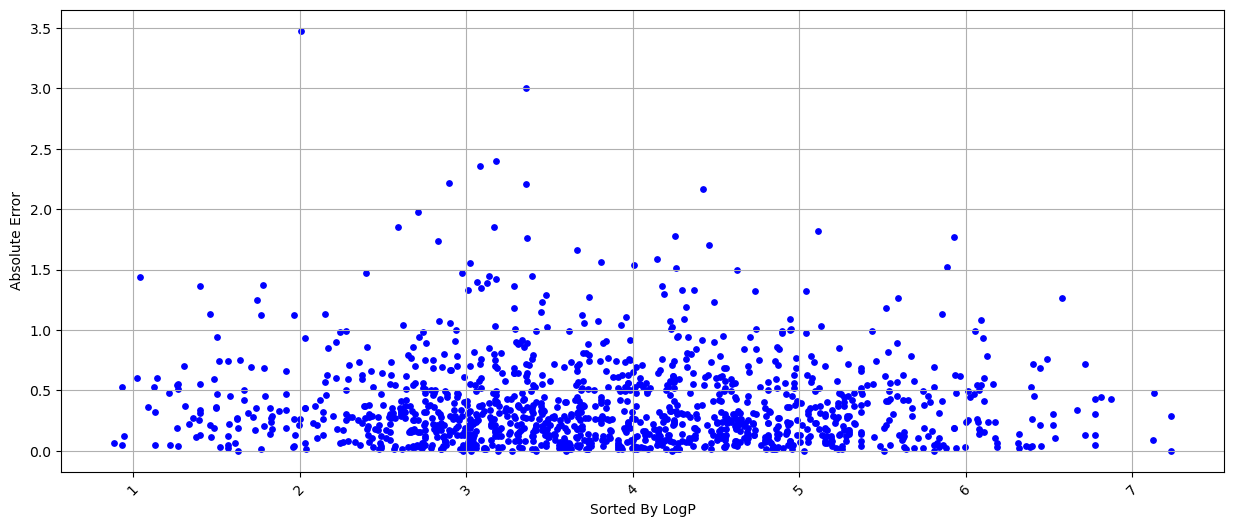

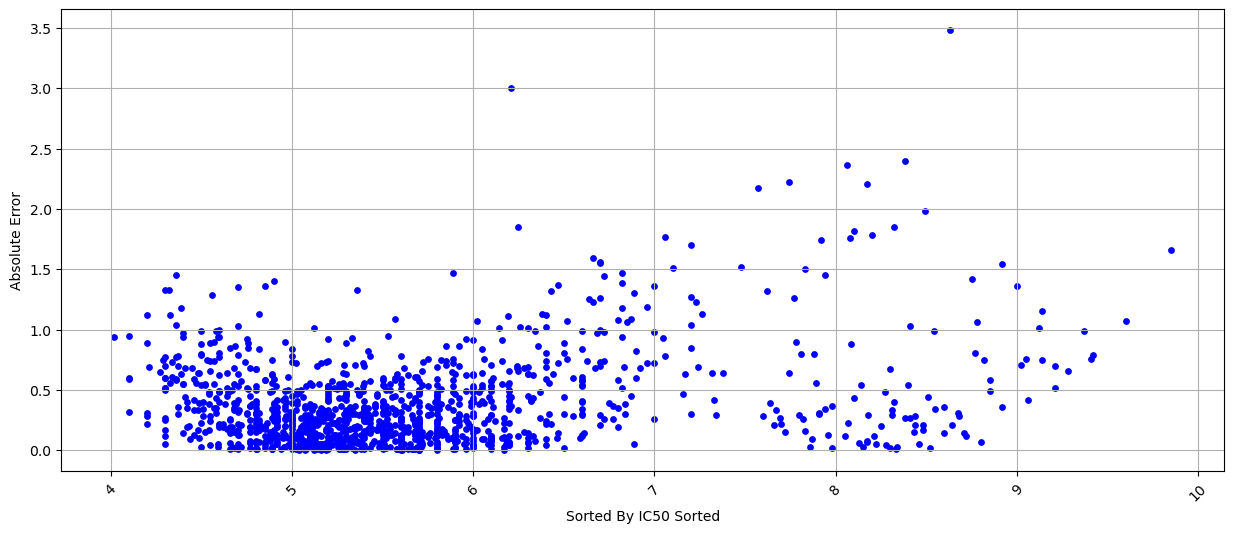

In [38]:
import matplotlib.pyplot as plt

plot_graphs(df, results_df)

In [45]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def perform_fcv(X, y, smiles, model, k=10, sort_by=None, additional_info=None):
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]

    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k

    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        
        X_test = X[start:stop]
        y_test = y[start:stop]
        smiles_test = smiles[start:stop]
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    # Optionally, save the results to a DataFrame
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        'Sort By': sort_by_all
    })

    # Saving to CSV (optional)
    results_df.to_csv("fcv_results.csv", index=False)

    # Return the DataFrame for further use or analysis
    return results_df


In [47]:
# Example Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df = perform_fcv(X, y, smiles, rf_model, sort_by=y, additional_info=y)


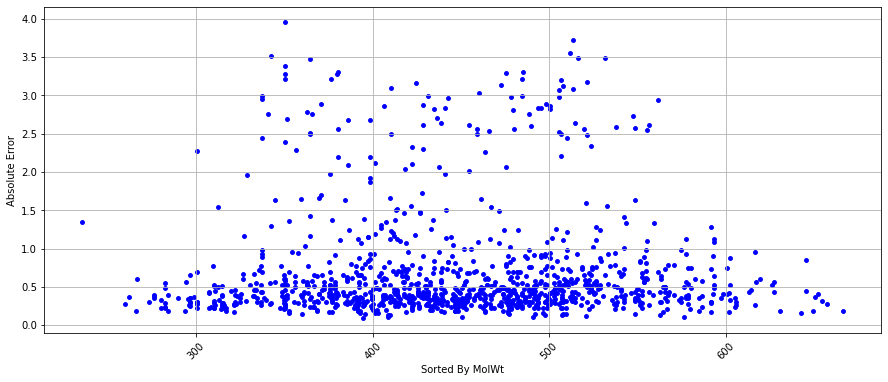

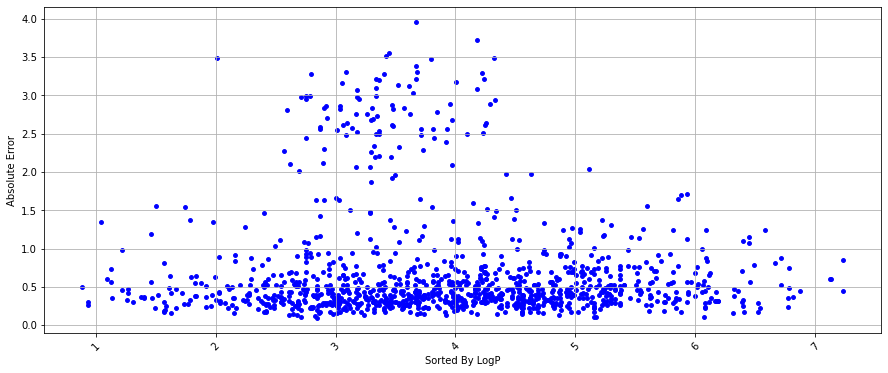

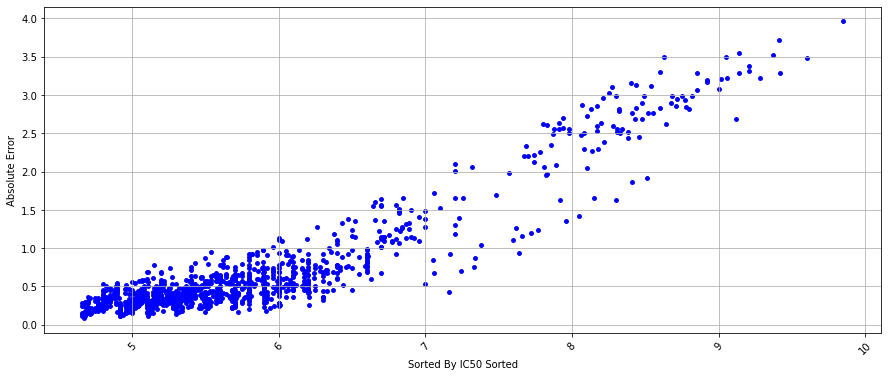

In [49]:
plot_graphs(df, results_df)

In [50]:
results_df = perform_fcv(X, y, smiles, rf_model, sort_by=MolWt, additional_info=MolWt)


In [53]:
results_df

,Standardized_SMILES,True Values,Predictions,Sort By
0,O=C1N(CCN2Cc3ccccc3C2)CCN1c1ccc2occc2c1,5.10,5.07980,347.418
1,O=C1N(CCN2CC3CCC(CC3)C2)CCN1c1cccc(Cl)c1,6.40,5.37470,347.890
2,NC(=O)c1c[nH]c2ccc(-c3cccnc3)cc2c1=NC1CCOCC1,5.68,5.93230,348.406
3,CCC(CC)CN=c1c(C(N)=O)c[nH]c2ccc(-c3cccnc3)cc12,6.17,5.75870,348.450
4,CCC(CC)CN=c1c(C(N)=O)c[nH]c2ccc(-c3ccncc3)cc12,6.21,5.74600,348.450
...,...,...,...,...
1131,COc1cc(C(O)(CCn2ccnc2)C(c2cc3cc(Br)ccc3nc2OC)c...,5.24,5.47140,650.530
1132,CCOc1cc(C(O)(CCN(C)C)C(c2cc3cc(Br)ccc3nc2OC)c2...,4.88,5.43910,652.586
1133,CCOc1cc(C(O)(CCN(C)C)C(c2cc3cc(Br)ccc3nc2OC)c2...,5.26,5.57335,654.602
1134,COc1cc(C(O)(CCN(C)C)C(c2cc(OC)c(OC)nc2OC)c2cc3...,5.23,5.58840,657.562


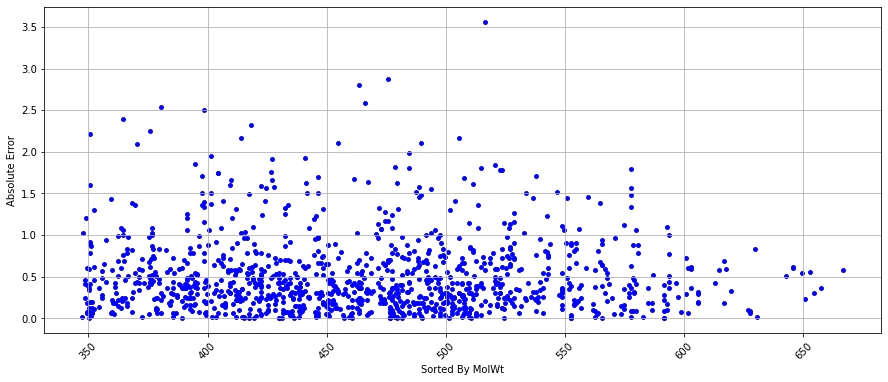

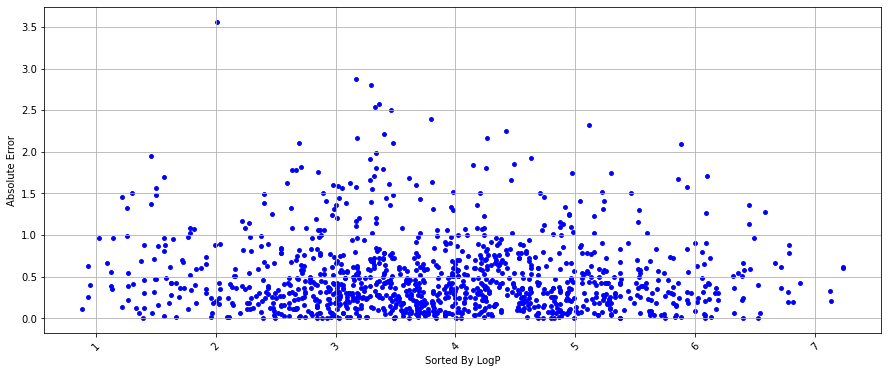

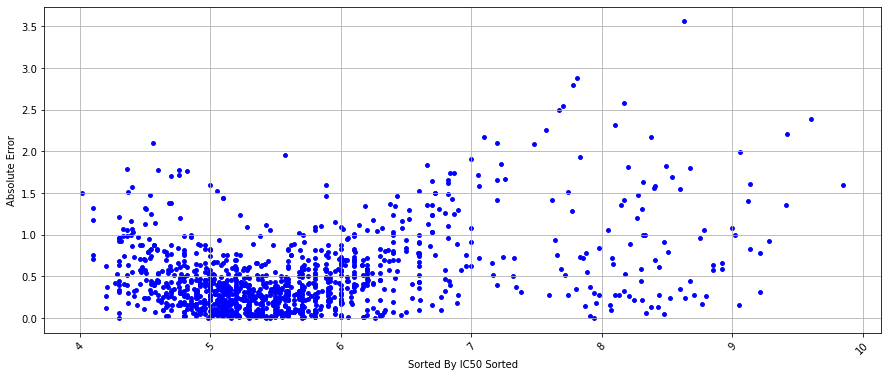

In [51]:
plot_graphs(df, results_df)

In [54]:
results_df = perform_fcv(X, y, smiles, rf_model, sort_by=LogP, additional_info=LogP)


In [55]:
results_df

,Standardized_SMILES,True Values,Predictions,Sort By
0,CC1(N)CCC(N=c2c(C(N)=O)c[nH]n3cc(-c4ccc(F)nc4)...,4.46,4.90220,2.37410
1,COc1ccc2ncc(F)c(CC(OCC(=O)O)C34CCC(NCc5ccc6c(n...,5.52,5.17150,2.38730
2,CCN1CCOC(C(=O)N2CCN(C(=O)Nc3ccc(Cl)c(Cl)c3)CC2)C1,5.30,4.77890,2.39020
3,N#Cc1ccc(Cn2cncc2CNC2CCN(C(=O)c3ccc[nH]c3=S)C2...,4.96,4.38130,2.39157
4,CS(=O)(=O)c1ccc(CCN2CCN(CCc3ccc([N+](=O)[O-])c...,6.82,7.08620,2.40110
...,...,...,...,...
1131,Cc1ccccc1-c1nc2cc(-c3ccc(Cl)cc3)sc2c(=O)n1CC1C...,5.68,5.28020,6.87422
1132,Cc1ccc2c(-c3nnc(SCCCN4CCc5cc6nc(C(C)(C)C)oc6c(...,6.40,5.87650,7.12292
1133,COc1nc2ccc(Br)cc2cc1C(c1ccccc1)C(O)(CCN(C)C)c1...,5.80,5.39545,7.13050
1134,Cc1ccc2c(-c3nnc(SCCC(C)N4CCc5cc6nc(C(F)(F)F)oc...,5.70,4.90230,7.23272


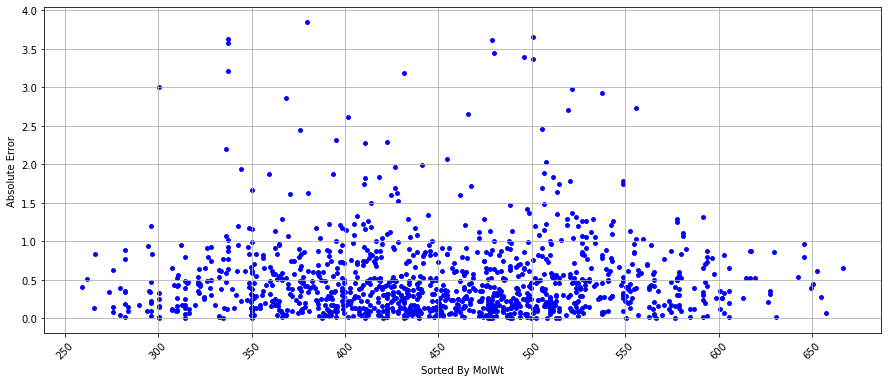

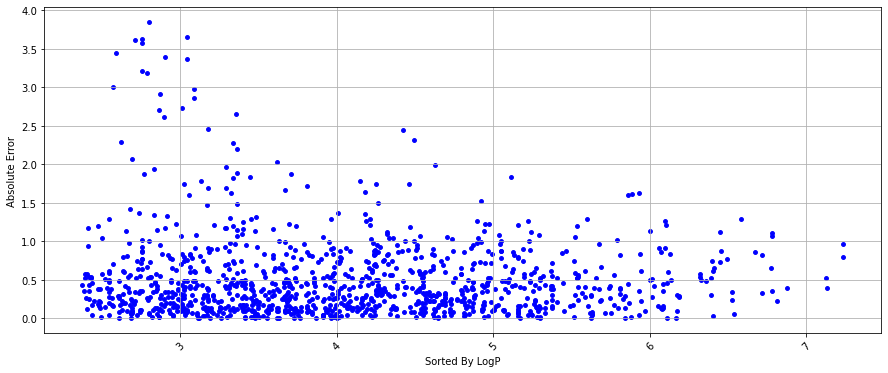

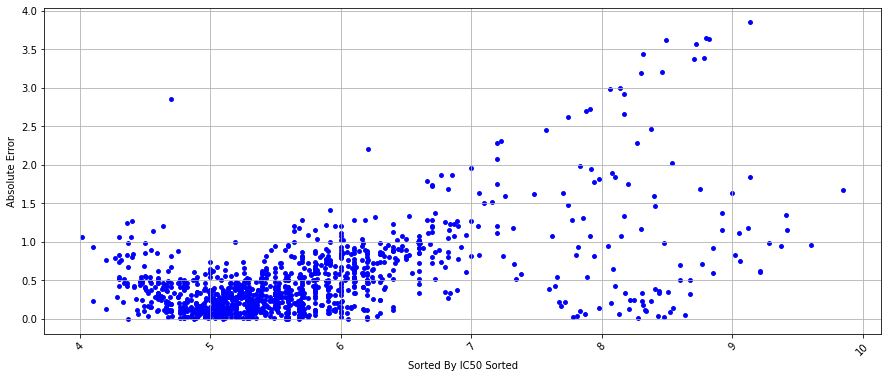

In [56]:
plot_graphs(df, results_df)

In [57]:
results_df = perform_fcv(X, y, smiles, rf_model, sort_by=None, additional_info=None)


In [58]:
results_df

,Standardized_SMILES,True Values,Predictions,Sort By
0,CC1CN(CCc2ccc([N+](=O)[O-])cc2)CCN1CCc1ccc([N+...,9.12,7.40520,9.12
1,CC1c2ccc(C#N)c(c2)Oc2cccc(c2)CN2CCC(NCc3cncn31...,4.89,5.39175,4.89
2,CC=Cc1cc(C(F)(F)F)cc(COCC2(c3ccc(F)cc3)CCN(C)C...,4.89,4.73370,4.89
3,CCC(C)C(C)CN1CCC(CNC(=O)c2cc(Cl)cc(Cl)c2)CC1,6.05,5.50970,6.05
4,CCC(CC)CN=c1c(C(N)=O)c(C)[nH]c2ccc(-c3cccnc3)cc12,6.17,5.26415,6.17
...,...,...,...,...
1131,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(-c2cscn2...,5.36,6.35145,5.36
1132,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C24CC5CC...,6.30,6.14510,6.30
1133,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C2CCCCC2...,6.87,6.28785,6.87
1134,c1cncc(-c2c[nH]c(C3Cc4c([nH]c5ccccc45)C(C4CCCC...,6.72,6.67940,6.72


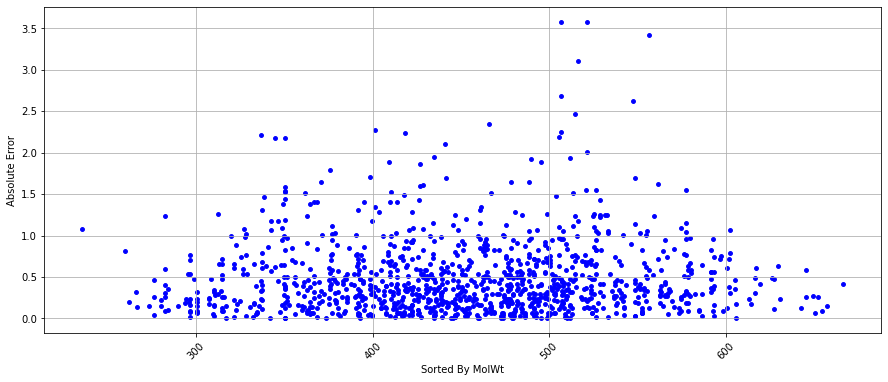

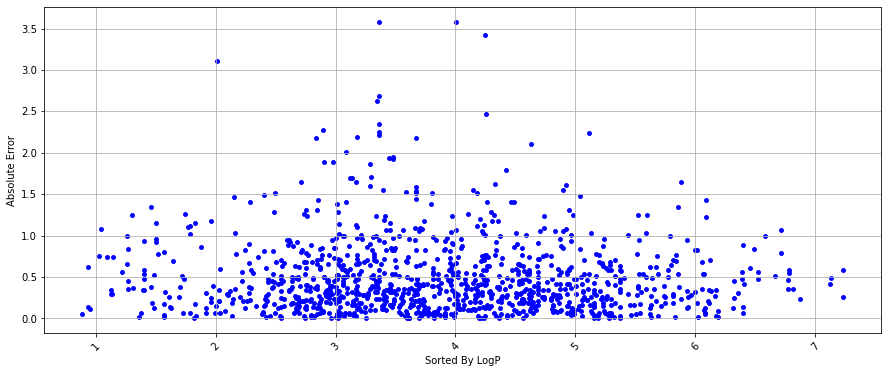

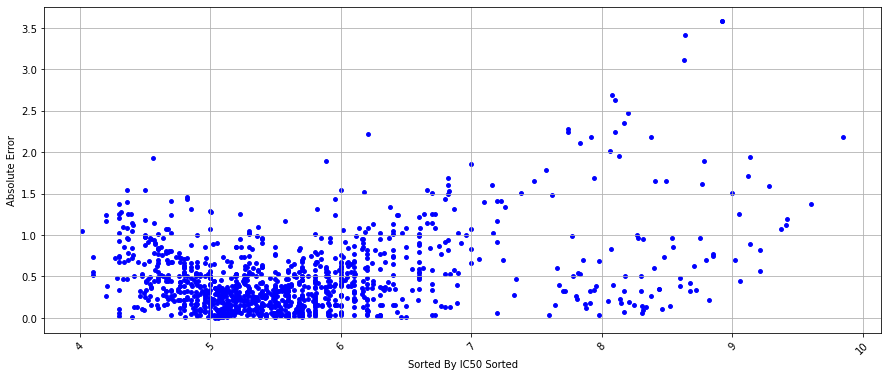

In [59]:
plot_graphs(df, results_df)

In [98]:
#FCV with strucutral similarity:

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

def get_fingerprints(smiles_list):
    fingerprints = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
            fingerprints.append(fp)
    return fingerprints

def cluster_compounds(fingerprints, n_clusters):
    distance_matrix = 1 - np.array([[DataStructs.FingerprintSimilarity(fp1, fp2) for fp2 in fingerprints] for fp1 in fingerprints])
    linkage_matrix = linkage(distance_matrix, method='ward')
    clusters = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
    return clusters


In [99]:
def perform_grouped_fcv(X, y, smiles, model, n_clusters):
    fingerprints = get_fingerprints(smiles)
    clusters = cluster_compounds(fingerprints, n_clusters)
    
    # Create a DataFrame to manage data
    df = pd.DataFrame({'X': list(X), 'y': y, 'smiles': smiles, 'cluster': clusters})
    df.sort_values('cluster', inplace=True)

    predictions_all = []
    true_values_all = []
    smiles_all = []
    cluster_all = []
    
    # Splitting groups by cluster
    unique_clusters = df['cluster'].unique()
    for i in range(len(unique_clusters)-1):
        train_df = df[df['cluster'] <= unique_clusters[i]]
        test_df = df[df['cluster'] == unique_clusters[i+1]]
        
        X_train = np.array(list(train_df['X']))
        y_train = train_df['y'].values
        X_test = np.array(list(test_df['X']))
        y_test = test_df['y'].values
        smiles_test = test_df['smiles'].values
        cluster_test = test_df['cluster'].values
        
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        predictions_all.extend(predictions)
        true_values_all.extend(y_test)
        smiles_all.extend(smiles_test)
        cluster_all.extend(cluster_test)
    
    # Optionally, save the results to a DataFrame
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        'Cluster': cluster_all
    })

    # Optionally, save results to CSV
    results_df.to_csv("fcv_results_with_clusters.csv", index=False)
 
    return results_df

In [100]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
results_df = perform_grouped_fcv(X, y, smiles, rf_model, n_clusters=15)

/tmp/ipykernel_241126/1788385666.py:22: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward')


In [101]:
results_df.Cluster.value_counts()

10    223
15    194
3     111
11     82
7      75
2      71
4      67
13     61
9      55
5      52
8      45
6      43
12     41
14     31
Name: Cluster, dtype: int64

In [102]:
results_df

,Standardized_SMILES,True Values,Predictions,Cluster
0,CCc1nc2ccc3c(c2s1)CCN(CCCSc1nnc(-c2cccc4nc(C)c...,6.80,8.4099,2
1,CCc1nn(C)c2cc3c(cc12)CCN(CCCSc1nnc(-c2cccc4nc(...,6.00,8.4319,2
2,CCc1nc2cc3c(c(C)c2o1)CCN(C(C)CCSc1nnc(-c2cccc4...,5.40,8.4319,2
3,CCc1nc2cc3c(cc2s1)CCN(CCCSc1nnc(-c2cccc4nc(C)c...,6.60,8.4319,2
4,CCc1nc2cc3c(cc2o1)CCN(CCCSc1nnc(-c2cccc4nc(C)c...,5.30,8.4319,2
...,...,...,...,...
1146,O=C(Nc1ccc(C(F)(F)F)c(Cl)c1)N1CCN(CC2CCCN(C3CC...,6.05,5.1421,15
1147,O=C(Nc1ccc(C(F)(F)F)cc1)N1CCN(CC2CCCN(C3CC3)C2...,5.20,5.0741,15
1148,O=C(Nc1ccc(Cl)c(C(F)(F)F)c1)N1CCN(CC2CCCN(C3CC...,5.20,5.1928,15
1149,O=C(NC1CCN(Cc2ccc3c(c2)OCO3)CC1)c1cc(=O)c2ccc(...,7.20,5.0379,15


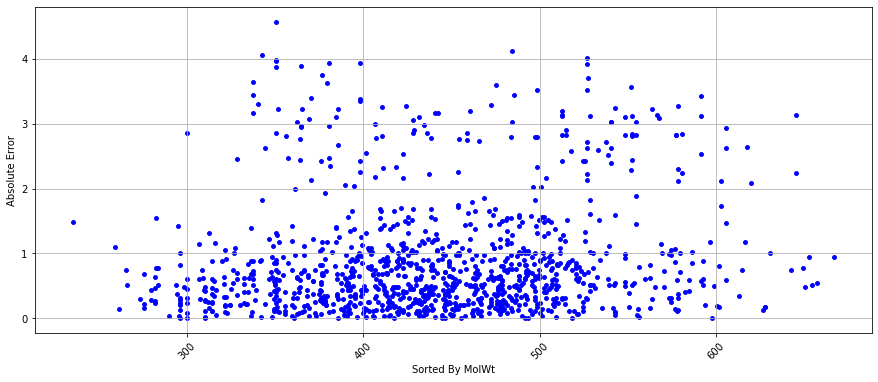

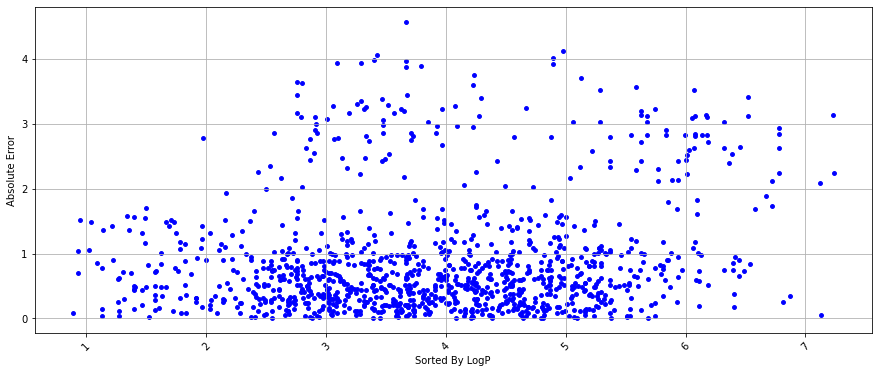

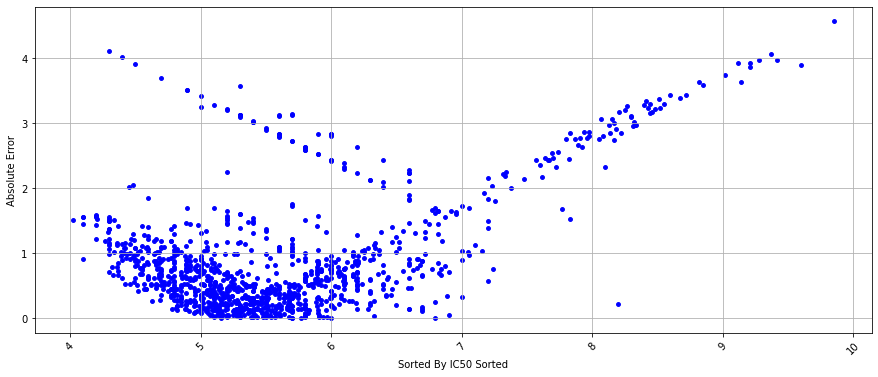

In [103]:
plot_graphs(df, results_df)

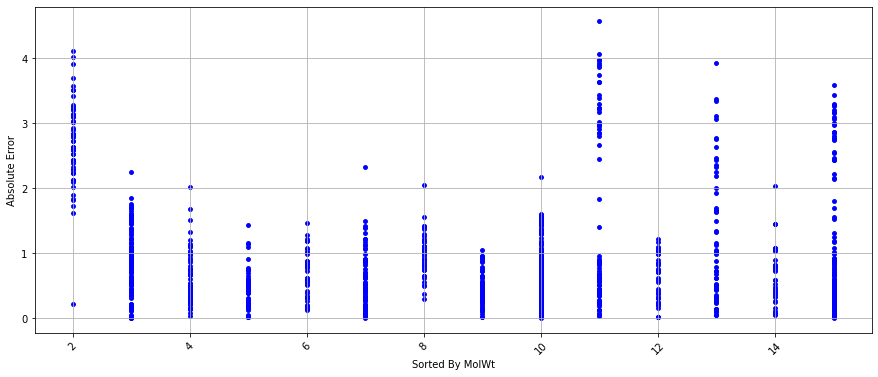

In [106]:
results_df =pd.merge(df, results_df, 
                         left_on="Standardized_SMILES", right_on="Standardized_SMILES")
    
# Calculate absolute errors and adjust results
results_df['Error'] = (results_df['True Values'] - results_df['Predictions']).abs().round(2)
results_df['True Values'] = results_df['True Values'].round(2)
results_df['Predictions'] = results_df['Predictions'].round(2)

# Plotting
plt.figure(figsize=(15, 6))
plt.scatter(results_df['Cluster'], results_df['Error'], color='blue', marker='o', s=15)
plt.xlabel('Sorted By MolWt')
plt.ylabel('Absolute Error')
plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
plt.grid(True)  # Optional: Adds grid lines for better readability
plt.show()